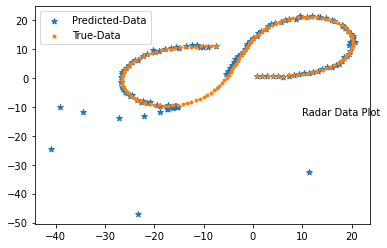

In [4]:
import import_ipynb
from KF import KF
from datapoint import DataPoint
from tools import calculate_jacobian, cartesian_to_polar, time_difference
import numpy as np
from tools import get_RMSE
import matplotlib.pyplot as plt
# from helpers import print_EKF_data

def parse_data(file):
	sensor_data=[]
	true_data=[]

	with open(file, 'r') as dat:
		lines = dat.readlines()

	for line in lines:
		x= line.split()

		if x[0]  == 'L':
			sensor_data_point = DataPoint({ 'timestamp': int(x[3]), 'name': 'lidar', 'x': float(x[1]), 'y': float(x[2])})
			
			true_data_point = DataPoint({ 'timestamp': int(x[3]), 'name': 'state', 'x': float(x[4]), 'y': float(x[5]), 'vx': float(x[6]), 'vy': float(x[7])})

		elif x[0]  == 'R':
			sensor_data_point = DataPoint({ 'timestamp': int(x[4]), 'name': 'radar', 'rho': float(x[1]), 'phi': float(x[2]), 'drho': float(x[3])})
			
			true_data_point = DataPoint({ 'timestamp': int(x[4]), 'name': 'state', 'x': float(x[5]), 'y': float(x[6]), 'vx': float(x[7]), 'vy': float(x[8])})

		sensor_data.append(sensor_data_point)
		true_data.append(true_data_point)

	return sensor_data,true_data

def start(data,kalmanFilter):
	global first_time
	timestamp = data.get_timestamp()
	x = np.matrix([data.get()]).T
	kalmanFilter.x=x
	kalmanFilter.P=P
	kalmanFilter.F=F
	kalmanFilter.Q=Q
	first_time=False
	return timestamp

def updateQ(dt):

	dt2 = dt * dt
	dt3 = dt * dt2
	dt4 = dt * dt3

	x, y = a

	r11 = dt4 * x / 4
	r13 = dt3 * x / 2
	r22 = dt4 * y / 4
	r24 = dt3 * y /  2
	r31 = dt3 * x / 2 
	r33 = dt2 * x
	r42 = dt3 * y / 2
	r44 = dt2 * y

	Q = np.matrix([[r11, 0, r13, 0],[0, r22, 0, r24],[r31, 0, r33, 0], [0, r42, 0, r44]])

	return Q

def kalman(data,kalmanFilter,timestamp):
	dt = time_difference(timestamp, data.get_timestamp())
	timestamp = data.get_timestamp()

	kalmanFilter.F[0,2],kalmanFilter.F[1,3]=dt,dt
	kalmanFilter.Q = updateQ(dt)
	kalmanFilter.predict()

	z = np.matrix(data.get_raw()).T
	x = kalmanFilter.x

	if data.get_name() == 'radar':        
	  
		px, py, vx, vy = x[0, 0], x[1, 0], x[2, 0], x[3, 0]
		rho, phi, drho = cartesian_to_polar(px, py, vx, vy)
		H = calculate_jacobian(px, py, vx, vy)
		Hx = (np.matrix([[rho, phi, drho]])).T
		R = radar_R 

	elif data.get_name() == 'lidar':

		H = lidar_H
		Hx = lidar_H * x
		R = lidar_R

	kalmanFilter.update(z, H, Hx, R)

	# if data.get_name() == 'lidar':
	# 	print x, kalmanFilter.x, "lidar"
	# elif data.get_name() == 'radar':
	# 	print x, kalmanFilter.x, "radar"

	return timestamp

def run(sensor_data,kalmanFilter):

	state_estimations=[]
	for data in sensor_data:
		if first_time:
			timestamp = start(data,kalmanFilter)
		else:
			timestamp = kalman(data,kalmanFilter,timestamp)
		
		x = kalmanFilter.x

		px, py, vx, vy = x[0, 0], x[1, 0], x[2, 0], x[3, 0]

		g = {'timestamp': data.get_timestamp(),
		'name': 'state',
		'x': px,
		'y': py,
		'vx': vx,
		'vy': vy }

		state_estimation = DataPoint(g)  
		state_estimations.append(state_estimation)
    
	return state_estimations

lidar_R = np.matrix([[0.01, 0],
					 [0, 0.01]])

radar_R = np.matrix([[0.01, 0, 0], 
                     [0, 1.0e-6, 0], 
                     [0, 0, 0.01]])

lidar_H = np.matrix([[1, 0, 0, 0],
                     [0, 1, 0, 0]])

P = np.matrix([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1000, 0], 
               [0, 0, 0, 1000]])

Q = np.matrix(np.zeros([4, 4]))
F = np.matrix(np.eye(4))

sensor_data,true_data = parse_data("obj_pose-laser-radar-synthetic-input.txt")

n = 4
a = (5, 5)	#accelerationNoise

kalmanFilter = KF(n)

first_time=True
state_estimations=run(sensor_data,kalmanFilter)

px, py, vx, vy = get_RMSE(state_estimations, true_data)

# print_EKF_data(sensor_data, true_data, state_estimations, 
#                RMSE = [px, py, vx, vy])

lidar_x_sensor=[]
lidar_y_sensor=[]
x_pred=[]
y_pred=[]
x_true=[]
y_true=[]

radar_r_sensor=[]
radar_p_sensor=[]
radar_d_sensor=[]

i=0
for s, p, t in zip(sensor_data, state_estimations, true_data):
	i+=1
	if i%4==0:
		continue
	if s.get_name() == 'lidar':
		x, y = s.get_raw()
		lidar_x_sensor.append(x)
		lidar_y_sensor.append(y)
		# x,y, vx, vy=p.get()
		# x_pred.append(x)
		# y_pred.append(y)

		# x,y, vx, vy=t.get()
		# x_true.append(x)
		# y_true.append(y)
	else:
		rho, phi, drho = s.get_raw()
		radar_r_sensor.append(rho)
		radar_p_sensor.append(phi)
		radar_d_sensor.append(drho)
		x,y, vx, vy=p.get()
		x_pred.append(x)
		y_pred.append(y)

		x,y, vx, vy=t.get()
		x_true.append(x)
		y_true.append(y)
		

# plt.scatter(lidar_x_sensor,lidar_y_sensor,label="Sensor-Data",marker="o")
plt.scatter(x_pred,y_pred,label="Predicted-Data",marker="*")
plt.scatter(x_true,y_true,label="True-Data",marker=".")
plt.legend()
plt.text(10,-13,"Radar Data Plot")
plt.show()